## Project milestone 2, CS-401 : Applied data analysis, group : TheAvengers


This Notebook can be divided in two parts. First, we handled our initial CMU dataset by enriching with other movies datasets and preprocess it (section 1 and 2 below). Then, we started with a first analysis which include section 3 to 5.

<a id="0"></a> 
 # Table of Contents  
1. [Import libraries and python files](#1)     
1. [Load the CMU dataset and additional datasets](#2)    
   2.1. [Load IMDB rating and movie from Kaggle datasets](#3)      
   2.2 [Load movie from Kaggle datasets](#4)    
3. [Let's start the analysis](#5)    
   3.1. [Pie chart of the countries, genres and langues categories](#6)    
   3.2. [Histogram of Revenues](#7)    
   3.3. [Evolution of revenues per year](#8)     
   3.4. [Histogram of Average Rating](#9)     
   3.5. [Evolution of the mean Average Rating per year](#10)     
   3.6. [Scatter plot of the average Rating and Revenue](#11)     
   3.7. [Pearson correlation](#12)     
   3.8. [Box plot of the number of known actor versus the log revenues](#13)       
   3.9. [Linear Regression - log revenue on number of known actors](#14)       
   3.10. [Box plot of the rating per number of known actors](#15)        
   3.11. [Linear regression - Rating on number of actors](#16)      
4. [Interaction matrix](#17)
5. [Network Analysis](#18)



<a id="1"></a> 
## 1. Import libraries and python files

In [48]:
import pandas as pd
import numpy as np
import json
import sys
import requests
import re
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

from data_loader import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id="2"></a> 
## 2. Load the CMU dataset and additional datasets

Lets first download our datasets and  extract the former countriers, the genres and the languages from each movie and create new columns feature that will be able to access more easily on the mentionned datas.

In [2]:
#loading the datasets
dataFrame_movie = load_cmu_movies()
dataFrame_character = load_cmu_characters()
#dataFrame_kaggle_movie = load_kaggle_movies()

#extracting the aforementioned features
dataFrame_movie['Country_List'] = dataFrame_movie['Countries'].apply(extract_features_names)
dataFrame_movie['Genre_List'] = dataFrame_movie['Genres'].apply(extract_features_names)
dataFrame_movie['Language_List'] = dataFrame_movie['Language'].apply(extract_features_names)

We decided to add additional datasets in order to complete our datas. However, trying to merge those datasets based on their Movies names doesn't work as there are movies that have the same Name but are in fact different. Therefore, it is complicated to differentiate movies based on their names. To overcome this issue, we identified each movie by its Freebase ID or its IMDB ID (depending on the dataset). To do so, we first need to retreive the IMDB ID (i.e. tconst column) based on the movie's Freebase ID.

In [3]:
#df_id_translation = get_wikidata_id_translations()
#display(df_id_translation)

#save the dataframe to a JSON file
#df_id_translation.to_json('id-translation.wikidata.json', orient='records', lines=True)

#replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

#load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

#display the loaded DataFrame
display(df_id_translation)

,tconst,Freebase ID
0,nm3628633,/m/0k83_1r
1,nm0012078,/m/02q173g
2,nm0394250,/m/03kfdk
3,tt0324924,/m/0ct2z8
4,nm0119354,/m/0356cy
...,...,...
990453,tt29521500,None
990454,nm2106941,None
990455,nm2186144,None
990456,nm4531538,None


Then, we can drop Nan and duplicates values and merge it with the CMU movies dataset 

In [4]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)

dataFrame_movie = pd.merge(dataFrame_movie, df_id_translation, on='Freebase ID', how='left')

print(dataFrame_movie.shape)

(81740, 16)


In [5]:
#compute percentage of missing values for df_mvoei
percentage_missing_values_year = (dataFrame_movie['Year'].isna().sum()/len(dataFrame_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (dataFrame_movie['Month'].isna().sum()/len(dataFrame_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Box office' is {format(percentage_missing_values_revenues, '.3f')}%.")

#percentage_missing_values_runtime = (dataFrame_movie['Runtime'].isna().sum()/len(dataFrame_movie['Runtime']))*100
#print(f"The percentage of missing values 'Runtime' is {format(percentage_missing_values_runtime, '.3f')}%.")

percentage_missing_values_tconst = (dataFrame_movie['tconst'].isna().sum()/len(dataFrame_movie['tconst']))*100
print(f"The percentage of missing values 'tconst' is {format(percentage_missing_values_tconst, '.3f')}%.")

The percentage of missing values 'Year' release date is 8.444%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 51.833%.
The percentage of missing values 'Box office' is 89.724%.
The percentage of missing values 'tconst' is 9.769%.


<a id="3"></a> 
### 2.1. Load IMDB rating and movie from Kaggle datasets

In [6]:
#load imdb dataset (from kaggle)
dataFrame_imdb_movie = load_movie_imdb_kaggle()
dataFrame_imdb_rating = load_rating_imdb_kaggle() 

In [7]:
#merge movies with rating 
df_movie_rating = pd.merge(dataFrame_imdb_movie, dataFrame_imdb_rating, on='tconst', how='inner')

In [8]:
#merge CMU dataset with IMDB dataset
dataFrame_movie = pd.merge(dataFrame_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
print(dataFrame_movie.shape)

(81740, 18)


<a id="4"></a> 
### 2.2. Load movie from Kaggle datasets

In [9]:
#load kaggle movies dataset
dataFrame_kaggle_movie = load_kaggle_movies()

In [10]:
#merging the two datasets
dataFrame_movie = dataFrame_movie.merge(dataFrame_kaggle_movie[['Name', 'tconst', 'Revenue']], on=['Name', 'tconst'], how='left', suffixes=('', '_df2'))

#use 'combine_first' to fill in the 'Revenue' values from df_kaggle_movie where they are NaN in df_movie
dataFrame_movie['Revenue'] = dataFrame_movie['Revenue'].combine_first(dataFrame_movie['Revenue_df2'])

#drop the 'Revenue_df2' column
dataFrame_movie.drop('Revenue_df2', axis=1, inplace=True)

#drop duplicates
dataFrame_movie = dataFrame_movie.drop_duplicates(subset='Wikipedia ID', keep='first')
print(dataFrame_movie.shape)

(81740, 18)


In [11]:
percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_rating = (dataFrame_movie['averageRating'].isna().sum()/len(dataFrame_movie['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")


The percentage of missing values 'Revenue' is 70.124%.
The percentage of missing values 'averageRating' is 31.271%.


Now, we want to regroup all actors that have played on the same movie and add this new features to our dataframe. We will fix a threshold to keep only actors that have played a certain number of movies (in order to make our analysis feasible due to the large size of the data).

In [12]:
#count the number of different movies each actor played in
actor_movie_count = dataFrame_character.groupby('Actor Name')['Freebase ID'].nunique().reset_index()

#rename the columns to match your requirements
actor_movie_count.columns = ['Actor Name', 'Number of Movies']

actor_movie_count_sorted = actor_movie_count.sort_values('Number of Movies', ascending=False).reset_index(drop=True)

#fix a threshold for the minimum number of movies an actor must have played in to keep the row, we fix it to 0 for the moment 
threshold = 0 

#filter dataFrame_character to only include actors who have played in more than the threshold number of movies
# First, we create a list of actors who meet the threshold criteria
actors_above_threshold = actor_movie_count_sorted[actor_movie_count_sorted['Number of Movies'] >= threshold]['Actor Name']

#filter the original DataFrame
dataFrame_character_filtered = dataFrame_character[dataFrame_character['Actor Name'].isin(actors_above_threshold)]

display(dataFrame_character_filtered)

,Wikipedia ID,Freebase ID,Release date,Character Name,Actor Birth,Actor Gender,Actor Height,Ethnicity,Actor Name,Actor Age At Movie Release,Freebase Actor/Character Map ID,Freebase Character ID,Freebase Actor ID
0,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
1,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
2,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
3,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
4,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450663,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450664,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450665,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450666,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [13]:
#group dataFrame_character by Freebase ID and list the characters 
dataFrame_actor = dataFrame_character_filtered.groupby('Freebase ID')['Actor Name'].apply(list).reset_index()

dataFrame_actor.columns = ['Freebase ID', 'List of known actors']

In [14]:
#now lets merge this new dataframe with the DataFrame_movie
dataFrame_movie = dataFrame_movie.merge(dataFrame_actor, on='Freebase ID', how='left')

#create a new column that count the number of known actors per movie based on the list of actors
dataFrame_movie['Number of known actors'] = dataFrame_movie['List of known actors'].apply(count_known_actors)

print(dataFrame_movie.shape)

(81740, 20)


Finally, we can take a look on the percentage of movies for which the list of actors is not available and then extract that will be useful for the analysis :

In [15]:
#lets first make a copy of the dataset 
test = dataFrame_movie.copy()

#we define a function on the data_loader file that allows us to check if a list is empty or not
test['Non-Empty actors'] = test['List of known actors'].apply(is_nonempty_list)

#compute the percentage of movies with empty or NaN actors lists
percentage_with_nonempty_actors = (test[test['Non-Empty actors']].shape[0] / test.shape[0]) * 100


print(f"The percentage of missing values 'List of known actors' is {format(100 - percentage_with_nonempty_actors, '.3f')}%.")

The percentage of missing values 'List of known actors' is 21.389%.


<a id="5"></a> 
## 3. Let's start with the analysis

Let's start by removing Nan values from the revenues as well as revenues less equal or equal to 1 :

In [16]:
dataFrame_movie = dataFrame_movie.dropna(subset=['Revenue'])
dataFrame_movie = dataFrame_movie[dataFrame_movie['Revenue'] >= 1]

#sanity check lets compute the percentage of missing values for the revenues 
percentage_missing_values_revenues = (dataFrame_movie['Revenue'].isna().sum()/len(dataFrame_movie['Revenue']))*100
print(f"The percentage of missing values 'Revenue' is {format(percentage_missing_values_revenues, '.3f')}%.")

The percentage of missing values 'Revenue' is 0.000%.


<a id="6"></a> 
### 3.1. Pie chart of the countries, genres and langues categories

We can start by tacking a look on the distributions of the following features : countries, genres and language. 

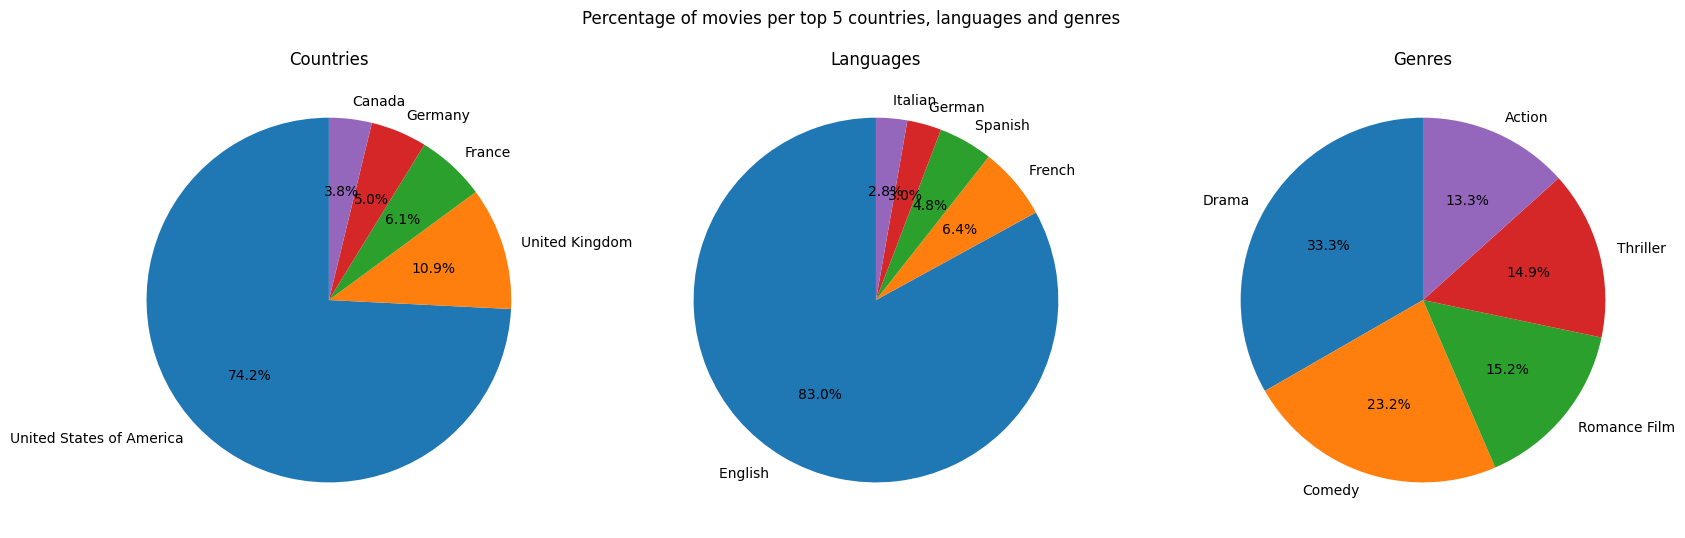

In [17]:
#show the percentage of movies per countries, genres and languages with including only the top 5 fives categories
top5_countries = (dataFrame_movie['Country_List'].apply(pd.Series).stack().value_counts()[:5])/dataFrame_movie.shape[0]
top5_languages = (dataFrame_movie['Language_List'].apply(pd.Series).stack().value_counts()[:5])/dataFrame_movie.shape[0]
top5_genres = (dataFrame_movie['Genre_List'].apply(pd.Series).stack().value_counts()[:5])/dataFrame_movie.shape[0]

# remove "Language" in the label because it is not useful 
labels_language = [label.replace('Language', '') for label in top5_languages.index]

#plot the pie charts
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Percentage of movies per top 5 countries, languages and genres')
axes[0].pie(top5_countries, labels=top5_countries.index, autopct='%1.1f%%', shadow=False, startangle=90)
axes[0].set_title('Countries')
axes[1].pie(top5_languages, labels=labels_language, autopct='%1.1f%%', shadow=False, startangle=90)
axes[1].set_title('Languages')
axes[2].pie(top5_genres, labels=top5_genres.index, autopct='%1.1f%%', shadow=False, startangle=90)
axes[2].set_title('Genres')
plt.show()

The United States stands at the forefront of the movies featured in our dataset, representing the majority of the film entries. This underscores our intentional focus on analyses centered around Hollywood. Consequently, we can narrow down our selection of actors to those renowned in the Hollywood sphere. This observation is further reinforced when considering the language of the movies. With nearly three-quarters of them in English, catering to an English-speaking audience, the revenues of each movie can be meaningfully compared. Notably, the prevalent genre in our dataset is Drama. While this fact does not pose an a priori impact on our analysis, it is an interesting observation.

<a id="7"></a> 
### 3.2. Histogram of Revenues

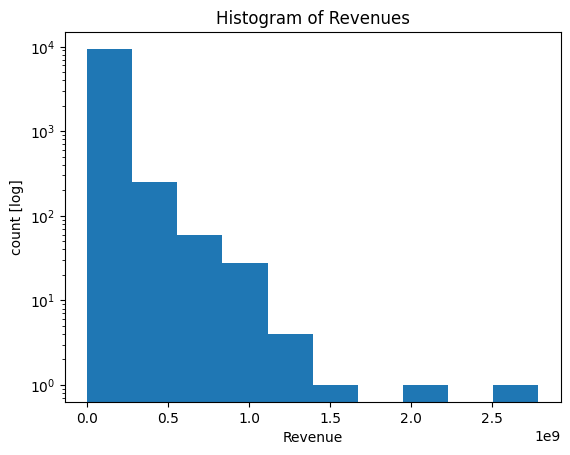

In [18]:
# Distribution of Revenues
#scales are very high on the x axis so we are gonna plot log(x) against y
dataFrame_movie['Revenue'].plot(kind='hist', logy=True)
plt.xlabel('Revenue')
plt.ylabel('count [log]')
plt.title('Histogram of Revenues')
plt.show()

In [19]:
dataFrame_movie['Revenue'].describe()

count    9.736000e+03
mean     4.594415e+07
std      1.116314e+08
min      1.000000e+00
25%      1.792486e+06
50%      9.325774e+06
75%      3.704153e+07
max      2.782275e+09
Name: Revenue, dtype: float64

We can see that the mean of the revenue is around 46 million USD. The frequency decrease with the magnitude of revenues. We also observe some outliers, the maximum (higher than 2 billions) are outliers in our dataset. Revenues near 0 \$ can be problem in the data but they also can be film that really underperformed. They are kept in the analysis. Please recall that we already removed 0 \$ revenues. 

<a id="8"></a> 
### 3.3. Evolution of mean Revenue per year

Text(0, 0.5, 'Mean Revenue [$]')

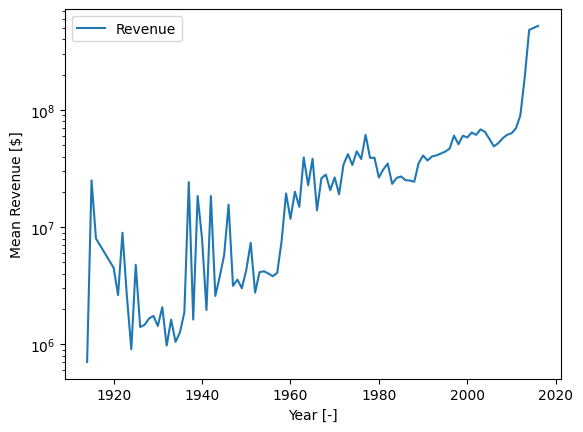

In [20]:
# Evolution of revenues during time 

df = dataFrame_movie[['Year','Revenue']].groupby(['Year']).mean()
df['std'] = dataFrame_movie[['Year','Revenue']].groupby(['Year']).std()
df['Year']=df.index
#drop first value 
df = df[df['Year'] > 1900]

#plot 
df.plot(x = 'Year', y='Revenue', logy= True)
plt.xlabel('Year [-]')
plt.ylabel('Mean Revenue [$]')


We can see that the log revenues seem to have an increasing trend from 1900 to 2023, especially in recent years, we can explain that by inflation. This is why we will take the consumer price index (CPI) as a measure of inflation to make revenues comparable over time.

<a id="9"></a> 
### 3.4. Histogram of Average Rating

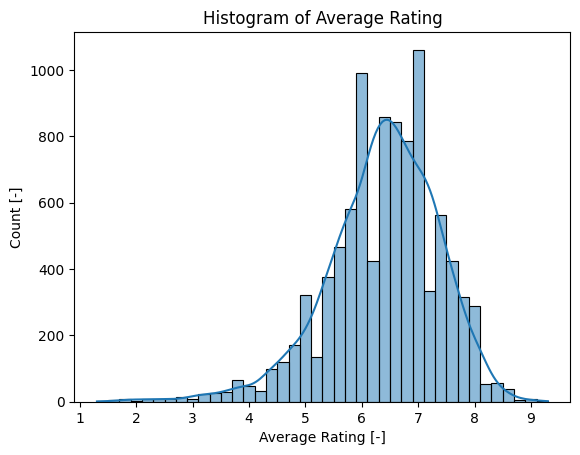

In [22]:
# Distribution of Average Ratings
sns.histplot(data=dataFrame_movie, x='averageRating', bins=40, kde = True)
plt.title('Histogram of Average Rating')
plt.xlabel('Average Rating [-]')
plt.ylabel('Count [-]')
plt.show()


In [23]:
#Descriptive data for the Average Rating
dataFrame_movie['averageRating'].describe()

count    9598.000000
mean        6.370598
std         0.996880
min         1.300000
25%         5.800000
50%         6.400000
75%         7.100000
max         9.300000
Name: averageRating, dtype: float64

We can see that the mean of the average rating is around 6.3 out of 10. Most of the ratings appears between 5.8 and 7.1. Not surprinsingly, no movie is rated with the maximal or the minimal rate since we are taking an average rating. 

<a id="10"></a> 
### 3.5. Evolution of the mean Average Rating per year

In [24]:
# Evolution of ratings during time 
df2 = dataFrame_movie[['Year','averageRating']].groupby(['Year']).mean()
df2['std'] = dataFrame_movie[['Year','averageRating']].groupby(['Year']).std()
df2['Year']=df2.index
df2 = df2[df2['Year'] > 1900]

Text(0, 0.5, 'Average Rating [-]')

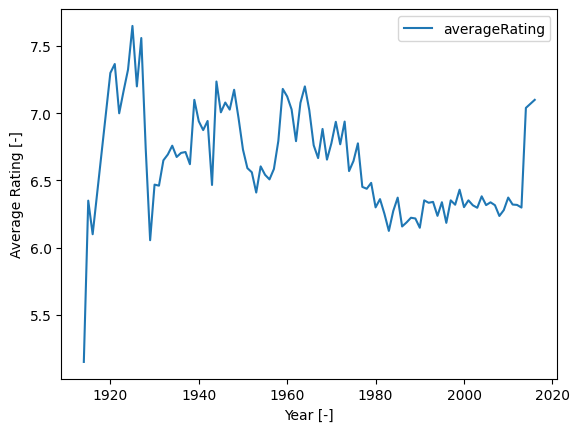

In [25]:
# plot of the Evolution of average rating
df2.plot(x = 'Year', y='averageRating')
plt.xlabel('Year [-]')
plt.ylabel('Average Rating [-]')

We can see that average ratings seem to be lower by one point for the second part of the 20th century, however, they have increased again in the last years. 

<a id="11"></a> 
### 3.6. Scatter plot of the average Rating and Revenue

Text(37.722222222222214, 0.5, 'Revenue [-]')

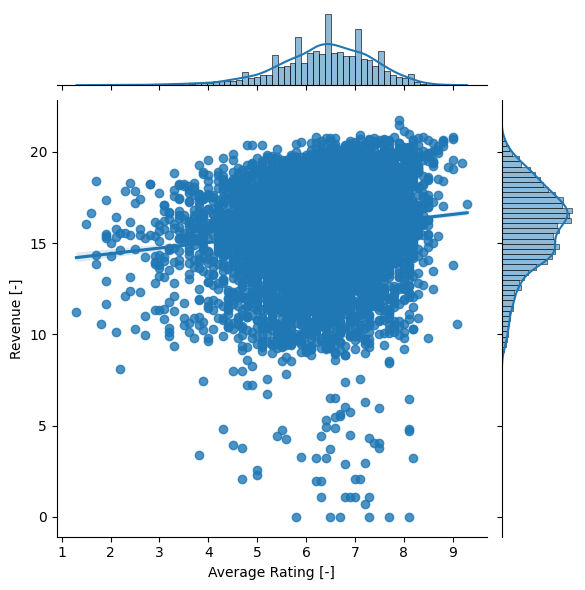

In [27]:
#scatter plot between the average Rating and the Revenue 
sns.jointplot(x=dataFrame_movie['averageRating'], y= np.log(dataFrame_movie['Revenue']), kind="reg")
plt.xlabel('Average Rating [-]')
plt.ylabel('Revenue [-]')

It is hard from the plot to see whether the two variables are correlated. So we try to compute the Pearson correlation.  

We try to compute it between the average rating and revenues. We compute also the correlation grouping by multiple variables such as the year, the language, and the countries. 
 
We obtain that the first have significant negative correlation, also when we group by the year.
When we group by year, we surprisingly an negative correlation between revenu and 

<a id="12"></a> 
### 3.7. Pearson correlation

In [29]:
# Pearson correlation when we group by year
df2['Revenue']= dataFrame_movie[['Year','Revenue']].groupby(['Year']).mean()['Revenue']
df2['Revenue'] = np.log(df2['Revenue'])
df2.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df2 = df2.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df2['averageRating'],df2['Revenue'])  

PearsonRResult(statistic=-0.3037096419084077, pvalue=0.00277137819433524)

In [30]:
# Pearson correlation when we group by Country
copy_data = dataFrame_movie.copy(deep=True)
copy_data['Country_List'] = copy_data['Country_List'].apply(tuple)
copy_data['Revenue'] = np.log(copy_data['Revenue'])
df3 = copy_data[['Revenue','Country_List']].groupby(['Country_List']).mean()
df3['averageRating']= copy_data[['averageRating','Country_List']].groupby(['Country_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['Revenue'])  

PearsonRResult(statistic=-0.07993829918128799, pvalue=0.05052507354609883)

In [31]:
# Pearson correlation when we group by Language
copy_data['Language_List'] = copy_data['Language_List'].apply(tuple)
df3 = copy_data[['Revenue','Language_List']].groupby(['Language_List']).mean()
df3['averageRating']= copy_data[['averageRating','Language_List']].groupby(['Language_List']).mean()
df3.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df3 = df3.dropna()  # Drop rows with NaN or inf
stats.pearsonr(df3['averageRating'],df3['Revenue']) 

PearsonRResult(statistic=0.004288463392971112, pvalue=0.9118428809295357)

<a id="13"></a> 
### 3.8. Box plot of the number of known actor versus the log revenues 

In [32]:
#extract Freebase ID, Name, Revenue, averageRating, numVotes, List of actors to a new DataFrame
dataFrame_reg = dataFrame_movie[['Freebase ID', 'Name', 'Revenue', 'averageRating', 'numVotes', 'List of known actors', 'Number of known actors']]

dataFrame_reg.rename(columns={"Freebase ID": "id", "Name" : "movie","Revenue":"revenue","averageRating":"rating", \
                                        "List of known actors":"actors","Number of known actors":"numbKnownActors"},inplace=True)

print(dataFrame_reg.shape)

(9736, 7)


In [33]:
#let's create a new feature names "log_revenue" that is the log of the revenue
dataFrame_reg['log_revenue']=dataFrame_reg.revenue.apply(lambda x : np.log(x))

#remove the movies with no known actors
dataFrame_reg=dataFrame_reg[dataFrame_reg["numbKnownActors"]>0]
print(dataFrame_reg.shape)

#apply following function to make the boxplot more readable
dataFrame_reg['numberOfKnownActors']=dataFrame_reg.numbKnownActors.apply(lambda x : transformCat(x))


(9494, 8)


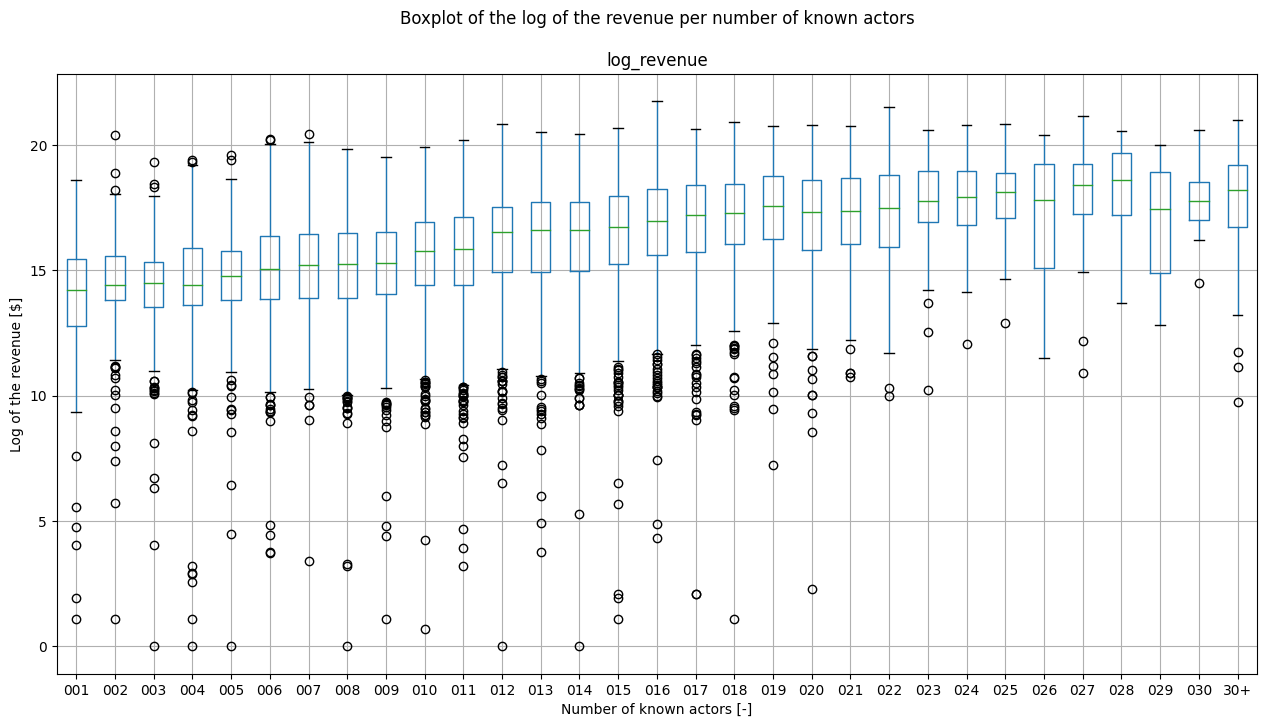

In [34]:
#plot a boxplot of the log of the revenue per number of known actors
ax = dataFrame_reg.boxplot(column=['log_revenue'], by=['numberOfKnownActors'],figsize=(15, 8))
plt.suptitle('Boxplot of the log of the revenue per number of known actors')
plt.xlabel('Number of known actors [-]')
plt.ylabel('Log of the revenue [$]')
plt.show()


We can see a positive trends meaning that higher revenues are linked with more known actors in a movie. Outliers seem to reduce when we increase the number of actor per movie. The whiskers are globally constant along this analysis.  

<a id="14"></a> 
### 3.9. Linear Regression - log revenue on number of known actors

In [35]:
for k in range(1,31):
    dataFrame_reg['n'+str(k)]=(dataFrame_reg.numbKnownActors == k)*1
dataFrame_reg['n31+']=(dataFrame_reg.numbKnownActors >= 31)*1

X_name = ['n'+str(x) for x in range(2,31)]
X_name+=['n31+']

In [36]:
X = dataFrame_reg[X_name].values
y = dataFrame_reg.log_revenue.values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     53.27
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.31e-292
Time:                        20:20:38   Log-Likelihood:                -21200.
No. Observations:                9494   AIC:                         4.246e+04
Df Residuals:                    9463   BIC:                         4.268e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9247      0.177     78.634      0.0

We can see that the probability of the F-statistic is highly close to 0 meaning that the set of independant variables (which are number of actor per movie dummies) are a significant impact on the logarithm of the revenue.

We can see that the R-squared is 0.144, which is intresting result knowing the fact that we used only dummies that enclosed similar information.

Most of the coefficient are independently significant as well. It seems that adding more known actors leads to higher revenue as we can see with the increase of the beta coefficient.

<a id="15"></a> 
### 3.10. Box plot of the rating per number of known actors

In [37]:
dataFrame_reg2=dataFrame_reg.dropna(subset=["rating"])

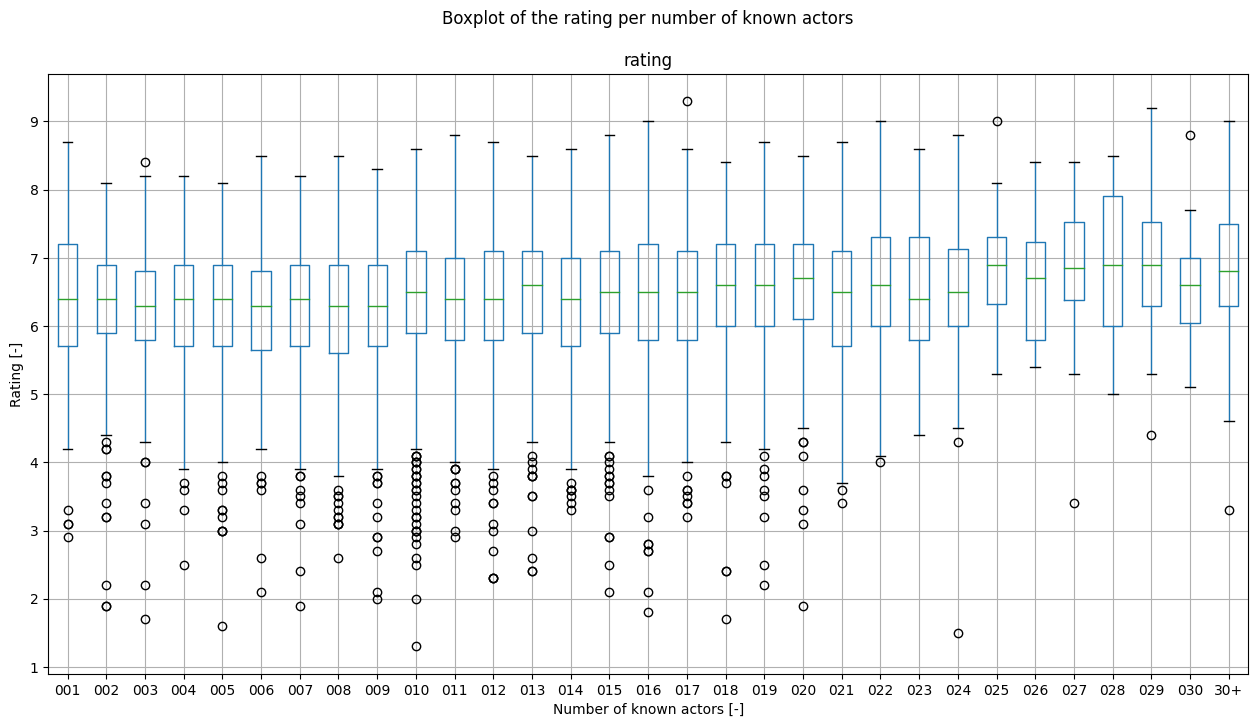

In [38]:
dataFrame_reg2.boxplot(column=['rating'], by=['numberOfKnownActors'],figsize=(15, 8))
plt.suptitle('Boxplot of the rating per number of known actors')
plt.xlabel('Number of known actors [-]')
plt.ylabel('Rating [-]')
plt.show()

We cannot see any clear trend. In the same way, outliers seem to reduce when we increase the number of actor per movie and the whiskers are globally constant along this analysis.  

<a id="16"></a> 
### 3.11. Linear regression - Rating on number of actors

In [39]:
X = dataFrame_reg2[X_name].values
y = dataFrame_reg2.rating.values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.001
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           9.86e-18
Time:                        20:20:50   Log-Likelihood:                -13138.
No. Observations:                9381   AIC:                         2.634e+04
Df Residuals:                    9350   BIC:                         2.656e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3966      0.081     78.869      0.0

We can see that the probability of the F-statistic (9.86e-18) which is still close to 0 meaning that the set of independant variables (which are number of actor per movie dummies) are a significant impact on the ratings.

We can see that the R-squared is 0.016, which is less intresting. The number of known actors has a lower impact on the rating.

However, most of the coefficient are not independently significant. It seems that adding more known actors leads to higher revenue as we can see with the increase of the beta coefficient.

<a id="17"></a> 
## 4. Interaction matrix

Now, the idea is to create a matrix. Each row of the matrix represent a differente movie. Every Column represents a different actor. The matrix returns 1 if the actor i plays in the movie j and 0 otherwise

In [64]:
df_count = dataFrame_movie.merge(dataFrame_character, on = 'Wikipedia ID', how = 'left') # POPULATE EACH MOVIE WITH ACTOR 
counter = df_count.groupby('Wikipedia ID')['Actor Name'].nunique() # We count the number of actor per movie

counter.describe()

count    9736.000000
mean       11.707683
std         6.457749
min         0.000000
25%         8.000000
50%        11.000000
75%        15.000000
max        87.000000
Name: Actor Name, dtype: float64

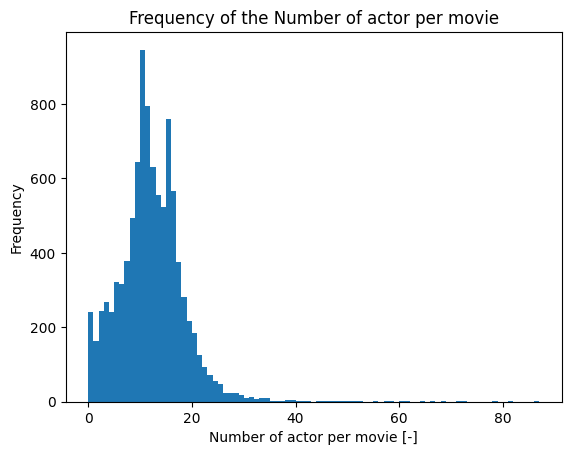

In [41]:
plt.hist(counter, bins =max(counter))

plt.title('Frequency of the Number of actor per movie')
plt.xlabel('Number of actor per movie [-]')
plt.ylabel('Frequency')
plt.show()

We can see that the number of known actors per movieis distributed around 10. We have some outlier as we can see in the maximal value. At this stage, some of the movie don't have any known actor. 

In [65]:
#create a binary matrix where rows represent movies, columns represent actors
binary_matrix = df_count.pivot_table(index='Name', columns='Actor Name', aggfunc='size', fill_value=0)

#reset the index to have movie name as a column
binary_matrix = binary_matrix.reset_index()

#fill NaN values with 0 (if necessary)
binary_matrix = binary_matrix.fillna(0)

#rename the columns with a prefix for clarity
binary_matrix.columns = ['Name'] + [ str(col) for col in binary_matrix.columns[1:]]

#set 'movie name' as the index 
binary_matrix.set_index('Name', inplace=True)

Let's take only actors that have played at leat 15 movies. 

In [73]:
#sum the number of movies per actor and drop the actors that played in less than 25 movies
actor_sum=binary_matrix.sum()
actors_to_drop=actor_sum[actor_sum<15].index

filtered_binary_matrix=binary_matrix.drop(actors_to_drop,axis=1)

In [74]:
display(filtered_binary_matrix)

,Aaron Eckhart,Aasif Mandvi,Abigail Breslin,Adam Baldwin,Adam Brody,Adam Goldberg,Adam Sandler,Adam Scott,Adrien Brody,Agnes Moorehead,...,William Sadler,William Shatner,Winona Ryder,Woody Allen,Woody Harrelson,Xander Berkeley,Zach Galifianakis,Zoe Saldana,Zooey Deschanel,Željko Ivanek
Name,,,,,,,,,,,,,,,,,,,,,
'Til There Was You,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"'night, Mother",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(500) Days of Summer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
(Untitled),0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*batteries not included,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zulu,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zyzzyx Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
¡Three Amigos!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Even with this filter, we still have a high number of actor (113). This is still a high number and if we want to test every pair of actor as a independant variable, we need (113*112)/2 beta. We still have the possibility to filter more using maybe more qualitative aspect. 

For each column of the filtered_binary_matrix, we multiply by every other column and them sum the new column

In [75]:
binary_matrix_column = filtered_binary_matrix.columns


matrix = np.zeros([len(binary_matrix_column),len(binary_matrix_column)])

i = 0
j = 0
# Iteration in every row and column to calculate the interaction
for col in binary_matrix_column:
    result = []
    j = 0
    for col2 in binary_matrix_column:
        #since the column are dummies, we can just multiply
        matrix[i,j]= (filtered_binary_matrix[col]* filtered_binary_matrix[col2]).sum()
        j+= 1
    i+=1

# We put the result in a dataframe
pairing_df = pd.DataFrame(matrix, columns=binary_matrix_column, index=binary_matrix_column)

We have our matrix of interaction. We will sort a list of actor that interract the most with his pear. We set the diagonal of the matrix equal to 0 and count the number of interaction of each actor

In [76]:
matrix_interaction = matrix - matrix*np.eye(len(binary_matrix_column))
pure_interaction = pd.DataFrame(matrix_interaction, columns=binary_matrix_column, index=binary_matrix_column)

pure_interaction = pure_interaction.sum(axis =1)

pure_interaction.sort_values(ascending=False)


Samuel L. Jackson    429.0
Steve Buscemi        399.0
Robert De Niro       374.0
Bruce Willis         373.0
Nicolas Cage         369.0
                     ...  
Doris Day             15.0
Tyrone Power          12.0
Alan Ladd             10.0
Ju Jin-mo              1.0
Ikue Otani             0.0
Length: 1237, dtype: float64

Now we have a list of actors who collaborate most frequently with their peers.


<a id="18"></a> 
## 5. Network Analysis

In [77]:
#keep only 40 actors with the most of interactions
list_actor_to_remove=list(pure_interaction.sort_values(ascending=False).index)[40:]

#drop the actors from the binary matrix
new_filtered_binary_matrix=filtered_binary_matrix.drop(list_actor_to_remove,axis=1)

In [78]:
binary_matrix_column = new_filtered_binary_matrix.columns


matrix = np.zeros([len(binary_matrix_column),len(binary_matrix_column)])

i = 0
j = 0
# Iteration in every row and column to calculate the interaction
for col in binary_matrix_column:
    result = []
    j = 0
    for col2 in binary_matrix_column:
        #since the column are dummies, we can just multiply
        matrix[i,j]= (filtered_binary_matrix[col]* filtered_binary_matrix[col2]).sum()
        j+= 1
    i+=1

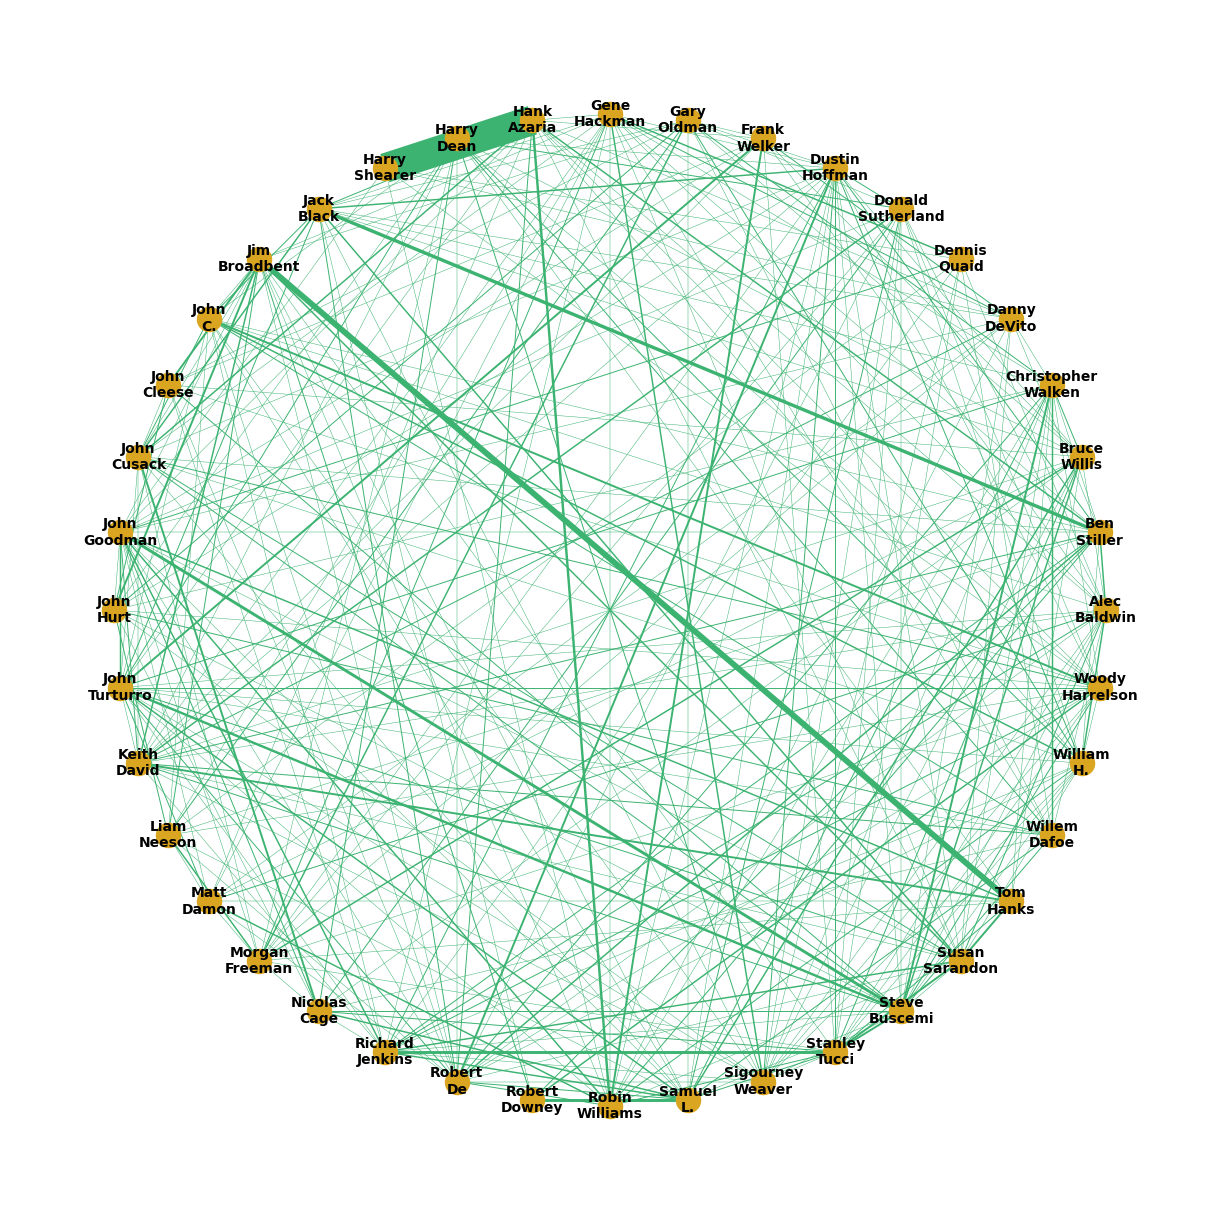

In [79]:
actors=new_filtered_binary_matrix.columns
movie_matrix=matrix


#create the graph
G = nx.Graph()

#add nodes to it
G.add_nodes_from(actors)

# Add edges to the graph with weights from the matrix
for i in range(len(actors)):
    for j in range(i + 1, len(actors)):
        weight = movie_matrix[i][j]
        if weight > 0:
            G.add_edge(actors[i], actors[j], weight=weight)


plt.figure(figsize=(12, 12))

#use a circular layout
pos = nx.circular_layout(G)

#calculate edge widths based on the logarithm of the number of movies
edge_widths = [0.35*weight for actor1, actor2, weight in G.edges(data='weight')]

#draw the graph with variable edge widths and green edges
nx.draw(G, pos, with_labels=False, node_size=300, node_color='goldenrod', font_size=8, width=edge_widths, edge_color='mediumseagreen')

#draw node labels with line breaks
node_labels = {actor: f"{actor.split()[0]}\n{actor.split()[1]}" for actor in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_weight='bold', font_color='black', font_size=10)

plt.show()

Each node represents an actor. The width of the edge between two nodes is proportional to the number of movies the two actors (two nodes) played togheter. To construct this graph, we restrict ourselves to actors with most interaction wth other actors through movies. We plan to use the same restrictions to make assessment about the contribution/interaction to revenue of the movie. Finally, we plan to modify the network plot in order to make it more readable. 